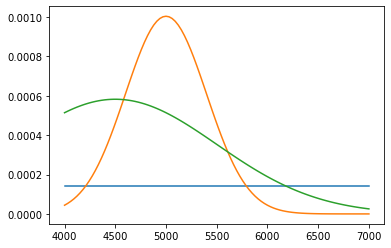

In [1]:
## something to explain template scaling etc. for pyhf ##
import numpy as np
# set reproducible seed
np.random.seed(210187)
import matplotlib.pyplot as plt

## cook up some models for our actual templates that we can use to generate a toy ##

mrange = (4000,7000)
bins = 25
x = np.linspace(*mrange,100)

# combinatorial (flat line)
from scipy.stats import uniform
comb = uniform(*mrange)

# B+
from scipy.stats import norm
bp = norm(5000,400)
bpn = np.diff( bp.cdf(mrange) )

# misid
mis = norm(4500,1000)
misn = np.diff( mis.cdf(mrange) ) 


# let's plot the normalised models
plt.plot(x,comb.pdf(x))
plt.plot(x,bp.pdf(x)/bpn)
plt.plot(x,mis.pdf(x)/misn)


<BarContainer object of 25 artists>

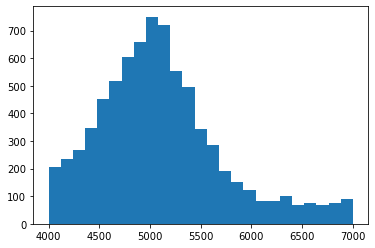

In [2]:
## now make a toy representing the actual data
## for this we need to define how much of each PDF contributes
# so let's say it's 0.2*combinatorial, 0.2*msid and 0.6*comb 

def generate(pdfs, ylds, mrange, nevents):
    
    values = []
    for pdf, yld in zip(pdfs,ylds):
        n = 0
        while n < yld*nevents:
            v = pdf.rvs()
            if v >= mrange[0] and v <= mrange[1]:
                values.append(v)
                n += 1
    return values

# gen 10000 data events
nevents = 10000

data = generate( [comb, mis, bp], [0.2,0.2,0.6], mrange, nevents )

# now generate some random "weights" for the data
dataws = np.random.uniform(-0.5,2,size=len(data))

# AFAIK numpy hitsogram doesn't store weight sums so need a boost histogram for this
import boost_histogram as bh

def hist(vals, wts, bins=25, range=None):
    range = range or (np.min(vals),np.max(vals))
    h = bh.Histogram( bh.axis.Regular(bins,*range), storage=bh.storage.Weight() )
    h.fill( vals, weight=wts)
    return h

# draw the template (not errors are hidden and will not the be sqrt because of the weights)
datah = hist(data, dataws, bins, mrange)
plt.bar(datah.axes[0].centers, datah.view().value, width=datah.axes[0].widths)

In [5]:
## now make each template
## we will also generate toys for these but this have much different statistcal size in comaprison to the nominal data template

# combinatorial (comes from event mixing let's assume it's total size is 5x that of the data)
comb_evs = generate( [comb], [1], mrange, 5*nevents )
# and some random weights for combinatorial (in reality the product of sweights and GBR weights)
comb_wts = np.random.uniform(-0.5,2,size=len(comb_evs))
# histogram it
combh = hist(comb_evs, comb_wts, bins, mrange)

# misid (comes from specific misId sample assume it's total size is 2x that of data)
misid_evs = generate( [mis], [1], mrange, 2*nevents)
# and some random weights for the misiD (in reality the product of sweights and midis weights)
misid_wts = np.random.uniform(-0.5,2,size=len(misid_evs))
# histogram it
misidh = hist(misid_evs, misid_wts, bins, mrange)

# b+ (comes from CF mode so size is much bigger than data ~400*)
bp_evs = generate( [bp], [1], mrange, 400*nevents)
# and some random weights (in reality come from sweights of that sample)
bp_wts = np.random.uniform(-0.5,2,size=len(bp_evs))
# histogram it
bph = hist(bp_evs, bp_wts, bins, mrange)



<ErrorbarContainer object of 3 artists>

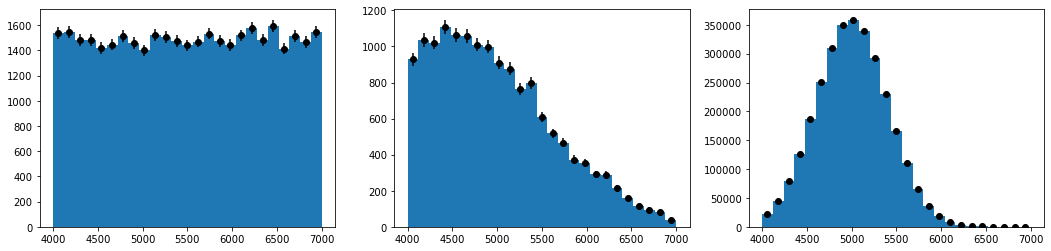

In [14]:

# can draw the templates as well
fig, ax = plt.subplots(1,3,figsize=(18,4))
ax[0].bar( combh.axes[0].centers, combh.view().value, width=combh.axes[0].widths, zorder=0 )
ax[0].errorbar( combh.axes[0].centers, combh.view().value, combh.view().variance**0.5, fmt='ko', zorder=1 )

ax[1].bar( misidh.axes[0].centers, misidh.view().value, width=misidh.axes[0].widths, zorder=0 )
ax[1].errorbar( misidh.axes[0].centers, misidh.view().value, misidh.view().variance**0.5, fmt='ko', zorder=1 )

ax[2].bar( bph.axes[0].centers, bph.view().value, width=bph.axes[0].widths, zorder=0 )
ax[2].errorbar( bph.axes[0].centers, bph.view().value, bph.view().variance**0.5, fmt='ko', zorder=1 )




In [20]:
## now sorting out the templates as if we were passing them to pyhf ##
## so now we can get what pyhf calls delta_sb for each bin, b, and each template, s
## this is the fractional error in each bin 

comb_dsb = combh.view().variance**0.5 / combh.view().value
misid_dsb = misidh.view().variance**0.5 / misidh.view().value
bp_dsb = bph.view().variance**0.5 / bph.view().value

## now the variances for each are these errors squared
comb_dsb2 = combh.view().variance/ combh.view().value**2
misid_dsb2 = misidh.view().variance / misidh.view().value**2
bp_dsb2 = bph.view().variance / bph.view().value**2

## and then the total error (the sum over s) delta^2_b
db2 = np.sum( [comb_dsb2, misid_dsb2, bp_dsb2], axis=0)

## so we now have what we are going to pass to pyhf as the Beeston-Barlow-lite variation in each bin 
## (note we have the variance in each bin db2, the error is db2**0.5)


In [31]:
## now we have to the scaling of the templates according to the Bohm and Zech thing
## this says that the observed number is weighted should be n' where n' = sum(w_i)/s_i
## and the template expectation number mu' should be mu' = mu_i/s_i
## where s_i = sum(w2)/sum(w)
## all of these weights are for the data template weights

## so we get our data histogram and work out si
si = datah.view().variance / datah.view().value

## so datah now needs scaling 
data_n = datah.view().value / si
# use np.rint(data_n) if it needs to be an integer

## and each template needs scaling
## Julian says it needs to be normalised first and then corrected

comb_mu = (1/combh.sum().value) * combh.view().value / si
misid_mu = (1/combh.sum().value) * misidh.view().value / si
bp_mu = (1/bph.sum().value) * bph.view().value / si

## now we have everything we need i think: n' (data), mu' (each template scaled) and db2 (Beeston-Barlow error)
print( 'n\': \n', data_n)
print( 'mu\' (comb): \n', comb_mu)
print( 'mu\' (mid): \n', misid_mu)
print( 'mu\' (b+ ): \n', bp_mu)
print( 'db2: \n', db2)


n': 
 [141.08232067 168.73313103 186.89161485 237.45179265 306.54757968
 351.90835737 399.7958746  455.49358099 515.29546425 509.7745526
 389.29388222 346.03476559 238.91812241 197.3244035  126.20903574
 104.47763495  80.17946322  56.70768208  54.35181527  70.47617891
  46.95288784  50.05996919  44.66792328  47.88417285  65.62280151]
mu' (comb): 
 [0.0283929  0.02989218 0.02771439 0.02716694 0.02584835 0.02633497
 0.0269548  0.02707824 0.02582415 0.02887805 0.02852331 0.02772895
 0.02700591 0.02741015 0.02733002 0.02744265 0.02555695 0.02812707
 0.02793752 0.02815459 0.02883433 0.02467535 0.02648735 0.02559019
 0.03005902]
mu' (mid): 
 [0.01717503 0.02007565 0.01913415 0.02027154 0.01936078 0.01930009
 0.01798289 0.0185638  0.01675561 0.01662355 0.01442583 0.0150359
 0.0114388  0.00965294 0.00831415 0.00694119 0.00622462 0.00539466
 0.00507015 0.004082   0.00284913 0.00202202 0.00166959 0.00143462
 0.00076607]
mu' (b+ ): 
 [5.26443903e-03 1.06304929e-02 1.83396823e-02 2.87006646e-02
 4

<BarContainer object of 25 artists>

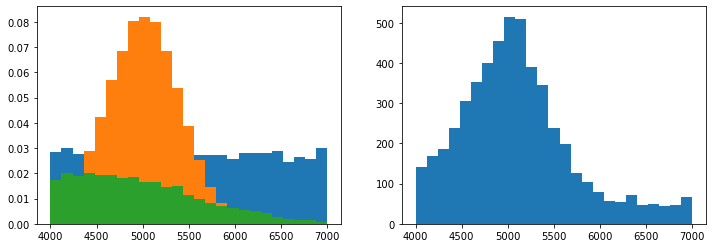

In [39]:
## draw them
centers = datah.axes[0].centers
widths = datah.axes[0].widths

fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].bar( centers, comb_mu, width=widths )
ax[0].bar( centers, bp_mu, width=widths )
ax[0].bar( centers, misid_mu, width=widths )

ax[1].bar( centers, data_n, width=widths)

<ErrorbarContainer object of 3 artists>

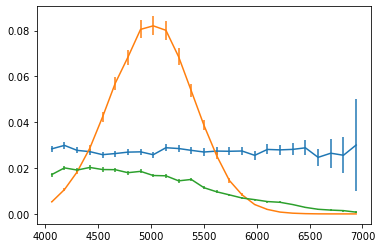

In [43]:
## can also visualise the Beeston-Barlow error budget
plt.errorbar( centers, comb_mu, (db2**0.5)*comb_mu  )
plt.errorbar( centers, bp_mu, (db2**0.5)*bp_mu )
plt.errorbar( centers, misid_mu, (db2**0.5)*misid_mu )

In [44]:
## an attempt at a pyhf fit then
import pyhf